In [1]:
import pandas as pd
import numpy as np
import glob

import os, gzip, shutil

from tqdm import tqdm

import polars as pl

import matplotlib.pyplot as plt
import itertools

# Unzip files

In [2]:
# dir_name = "/Users/hwunrow/Documents/GitHub/e6691-2024spring-project-cgnn-nhw2114/data/raw/safegraph/"

# def gz_extract(directory):
#     extension = ".gz"
#     for item in tqdm(os.listdir(directory)): # loop through items in dir
#       if item.endswith(extension): # check for ".gz" extension
#           gz_name = os.path.abspath(item) # get full path of files
#           file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
#           with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
#               shutil.copyfileobj(f_in, f_out)
#           os.remove(gz_name) # delete zipped file
        
# gz_extract(dir_name)

# Open first file and investigate columns

In [3]:
# def combine_batch_csv(dir):
#     """Combines Safegraph dataframes into one
#     """
#     csv_files = glob.glob(f'{dir}/*.csv.gz')

#     df_list = []

#     for filename in tqdm(csv_files):
#         df = pd.read_csv(example_file, compression='gzip')
#         df_list.append(df)

#     df = pd.concat(df_list, axis=0)

#     return df

In [4]:
dir = "../data/raw/safegraph/*.csv"
file_paths = glob.glob(dir)

df = pl.read_csv(file_paths[0])

In [5]:
def polars_sum_values_or_zero(x):
    if x == '':
        return 0
    else:
        return sum(json.loads(x).values())

# def pandas_sum_values_or_zero(x):
#     if pd.isna(x):
#         return 0
#     else:
#         return sum(json.loads(x).values())

df = df.with_columns(
    pl.col("VISITOR_HOME_AGGREGATION").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_AGGREGATION_TOTAL'),
    pl.col("VISITOR_HOME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_CBGS_TOTAL'),
    pl.col("VISITOR_DAYTIME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_DAYTIME_CBGS_TOTAL'),
)


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_91028/3749972135.py:14: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("VISITOR_HOME_AGGREGATION").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_AGGREGATION_TOTAL'),
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_91028/3749972135.py:15: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("VISITOR_HOME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_HOME_CBGS_TOTAL'),
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_91028/3749972135.py:16: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col("VISITOR_DAYTIME_CBGS").apply(polars_sum_values_or_zero).alias('VISITOR_DAYTIME_CBGS_TOTAL'),
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithout

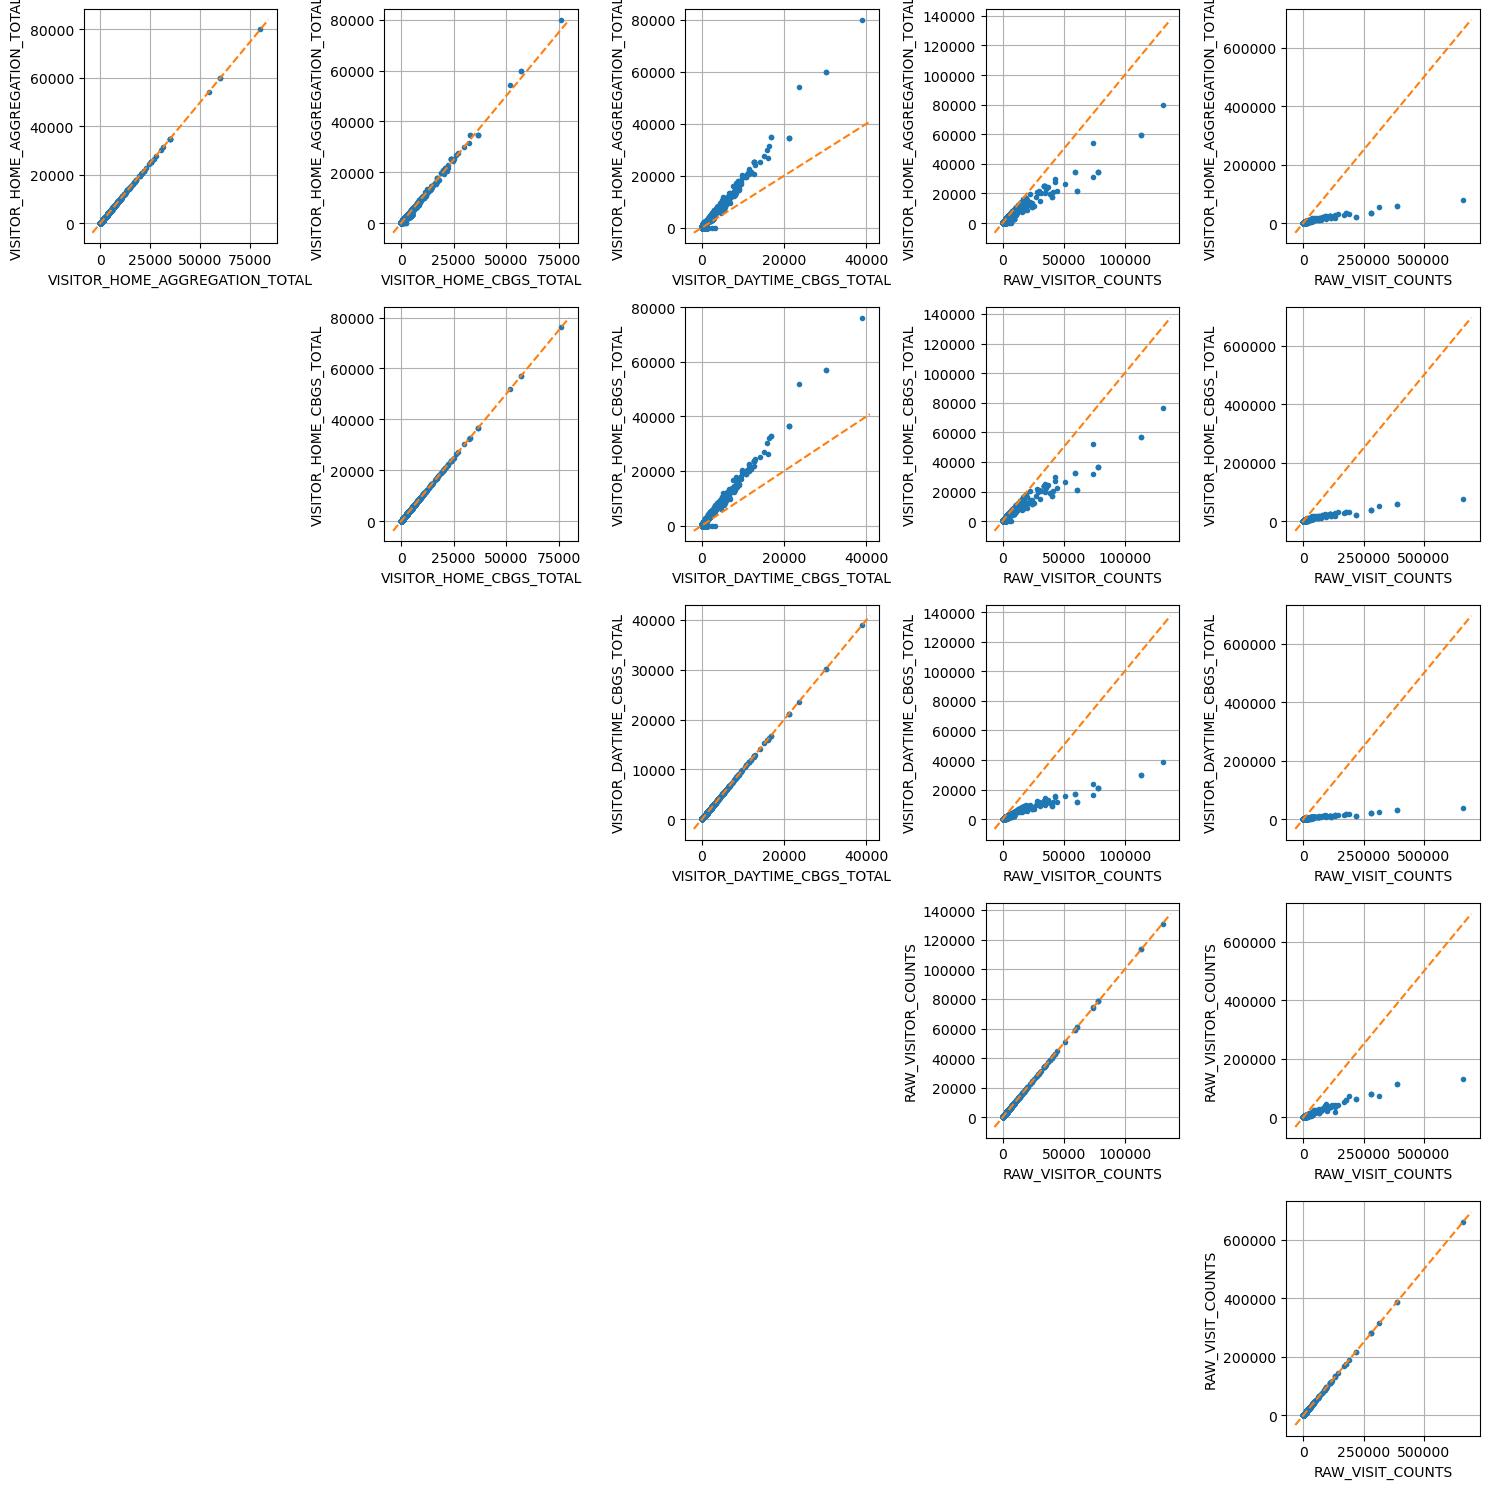

In [6]:
fig, axs = plt.subplots(figsize=(15,15), ncols= 5, nrows=5)

cols = ['VISITOR_HOME_AGGREGATION_TOTAL', 'VISITOR_HOME_CBGS_TOTAL', 'VISITOR_DAYTIME_CBGS_TOTAL', 'RAW_VISITOR_COUNTS', 'RAW_VISIT_COUNTS']
plot_col_pairs = list(itertools.product(cols, cols))

for i, ax in enumerate(axs.flatten()):
    col_a, col_b = plot_col_pairs[i]
    col = i % 5
    row = i // 5
    if col >= row:
        ax.plot(df[col_b], df[col_a], '.')
        x_vals = np.array(ax.get_xlim())
        ax.plot(x_vals, x_vals, '--')
    
        ax.set_xlabel(col_b)
        ax.set_ylabel(col_a)
        ax.grid()
    else:
        ax.set_axis_off()

plt.tight_layout()

In [7]:
# df.loc[:,['VISITOR_HOME_AGGREGATION_TOTAL', 'VISITOR_HOME_CBGS_TOTAL', 'VISITOR_DAYTIME_CBGS_TOTAL', 'RAW_VISITOR_COUNTS', 'RAW_VISIT_COUNTS']].sum(axis=0)
df.select(
    pl.col("VISITOR_HOME_AGGREGATION_TOTAL").sum(),
    pl.col("VISITOR_HOME_CBGS_TOTAL").sum(),
    pl.col("VISITOR_DAYTIME_CBGS_TOTAL").sum(),
    pl.col("RAW_VISITOR_COUNTS").sum(),
    pl.col("RAW_VISIT_COUNTS").sum(),
)

VISITOR_HOME_AGGREGATION_TOTAL,VISITOR_HOME_CBGS_TOTAL,VISITOR_DAYTIME_CBGS_TOTAL,RAW_VISITOR_COUNTS,RAW_VISIT_COUNTS
i64,i64,i64,i64,i64
28435742,26629594,13353389,34765969,71299124


```
VISITOR_DAYTIME_CBGS_TOTAL <<  VISITOR_HOME_CBGS_TOTAL \approx VISITOR_HOME_AGGREGATION_TOTAL < RAW_VISITOR_COUNTS << RAW_VISIT_COUNTS
```

# Open all files

In [33]:
path = "../data/raw/safegraph/*.csv"
df = pl.scan_csv(path, dtypes = {"POSTAL_CODE": pl.String}).filter(
    pl.col("VISITS_BY_DAY") != "",
    pl.col("VISITOR_HOME_AGGREGATION") != "",
)

df = df.with_columns(
    pl.col("DATE_RANGE_START").str.to_datetime(),
    pl.col("DATE_RANGE_END").str.to_datetime()
)



In [34]:
zip_county_map = pd.read_csv('../data/raw/ZIP_COUNTY_CROSSWALK.csv')
tract_zip_map = pd.read_csv('../data/raw/ZIP_TRACT_032020.csv')

# keep the zip-county pair that has the highest TOT_RATIO
zip_county_map = zip_county_map.sort_values(by=['ZIP', 'TOT_RATIO'], ascending=False)
zip_county_map = zip_county_map.drop_duplicates(subset='ZIP', keep='first')

# map codes to strings (probably should make everything ints, but it's just annoying since there are some alphnumeric postal codes in safegraph
zip_county_map['ZIP'] = zip_county_map['ZIP'].astype(str)
zip_county_map['COUNTY'] = zip_county_map['COUNTY'].astype(str)

tract_zip_map['ZIP'] = tract_zip_map['ZIP'].astype(str)
tract_zip_map['TRACT'] = tract_zip_map['TRACT'].astype(str)

# merge county to postal code of POI
df = df.join(pl.from_pandas(zip_county_map[['ZIP','COUNTY']]).lazy(), left_on='POSTAL_CODE', right_on='ZIP', how='left')

df = df.filter(
    pl.col('COUNTY').is_in(['36005', '36047', '36061', '36081', '36085'])
)


In [35]:
# count number of POIs with no county
# crap_df = df.select(
#     pl.col("COUNTY").is_null(),
#     pl.len()
# ).collect()

# crap_df['COUNTY'].sum() / crap_df['len'][0]

0.0

Around 7% of rows of Safegraph data does not have a postal code/ zip code that maps to a US county. Many of them are Canadian zip codes. Just drop them for now.

In [36]:
import polars.selectors as cs

decoded_df = df.select(
    pl.col('DATE_RANGE_START'),
    pl.col('DATE_RANGE_END'),
    pl.col('COUNTY'),
    pl.col("VISITOR_HOME_AGGREGATION").str.json_decode()
).unnest('VISITOR_HOME_AGGREGATION')

decoded_df = decoded_df.melt(id_vars=['DATE_RANGE_START','DATE_RANGE_END','COUNTY'], value_vars=cs.numeric(), variable_name='TRACT', value_name='VISITOR_HOME_AGGREGATION')
decoded_df = decoded_df.join(pl.from_pandas(tract_zip_map[['ZIP','TRACT']]).lazy(), left_on='TRACT', right_on='TRACT', how='left')
decoded_df = decoded_df.join(pl.from_pandas(zip_county_map[['ZIP','COUNTY']]).lazy(), left_on='ZIP', right_on='ZIP', how='left', suffix='_dest')
decoded_df = decoded_df.drop("TRACT", "ZIP")

In [ ]:
decoded_df = decoded_df.filter(
    ~pl.col('COUNTY').is_null(),
    ~pl.col('COUNTY_dest').is_null(),
    ~pl.col('VISITOR_HOME_AGGREGATION').is_null(),
)

nyc_df = decoded_df.group_by(by=["DATE_RANGE_START", "DATE_RANGE_END", "COUNTY", "COUNTY_dest"]).sum().collect()

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_93326/3864176317.py:7: DeprecationWarning: named `by` param is deprecated; use positional `*args` instead.
  nyc_df = decoded_df.group_by(by=["DATE_RANGE_START", "DATE_RANGE_END", "COUNTY", "COUNTY_dest"]).sum().collect()


In [ ]:
nyc_df = nyc_df.select(
    pl.col("COUNTY").cast(pl.Int16),
    pl.col("COUNTY_dest").cast(pl.Int16),
)

In [ ]:
from utils.codebook import FIPS_BOROUGH_MAP

In [ ]:
mobility_df = pd.concat(df_list)
mobility_df["path"] = mobility_df["origin"] + "_" + mobility_df["destination"]
mobility_df["date"] = pd.to_datetime(mobility_df["end"])

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)


for i, o in enumerate(mobility_df["origin"].unique()):
    paths = mobility_df.loc[mobility_df.origin == o, "path"].unique()
    for path in paths:
        ax[i].plot(
            mobility_df.loc[mobility_df['path'] == path, 'date'],
            mobility_df.loc[mobility_df['path'] == path, 'visitor_home_aggregation'].values, '-', label=path)
    ax[i].set_title(f"from {o}")
    ax[i].set_ylabel(r'visitor_home_aggregation')
    ax[i].grid()
    ax[i].legend()

fig.suptitle("Safegraph Mobility Data")
fig.savefig("../assets/safegraph.png")
